**集成方法**的关键是： 开发出大量近似独立的模型，然后把它们集成起来。

**集成方法**由两层算法组成：

- 底层算法，叫做**基学习器**。比如：支持向量机(SVM)、线性回归、k最近邻、二元决策树...

- 上层算法。比如： 投票(Bagging)、提升(Boosting)、随机森林(Random forests)...

本节是书中第六章集成方法的第一节二元决策树。

## 1) 二元决策树


### 用算法包构建二元决策树，可据此进行预测

下面的代码用算法sklearn.tree.DecisionTreeRegressor对红酒口感数据构建二元决策树，形成一个感性认识。

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# 获取红酒数据集
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(target_url, header=0, sep=";")
df.columns = ['非挥发性酸','挥发性酸','柠檬酸', '残留糖分', '氯化物', '游离二氧化硫','总二氧化硫', '密度', 
              'PH值', '亚硝酸盐', '酒精含量', '品质']

xData = df.values[:,:-1]; yData = df.values[:,-1] 
m, n = xData.shape

wineTree = DecisionTreeRegressor(max_depth=3)
wineTree.fit(xData, yData)

with open("wineTree.dot", 'w') as f:
    f = tree.export_graphviz(wineTree, out_file=f)

In [3]:
# 转换成图片
!dot -Tpng wineTree.dot -o wineTree.png

/bin/sh: 1: dot: not found


In [4]:
# 从图片中读取
plt.figure(figsize=(15, 15))
img=plt.imread("wineTree.png")
plt.imshow(img)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'wineTree.png'

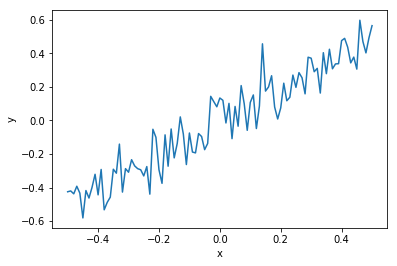

In [6]:
# 产生一组含标准正态随机扰动数据集
m = 100
x = np.arange(1+m)/m - 0.5
y = x + np.random.normal(scale=0.1,size=m+1)
plt.plot(x,y)
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

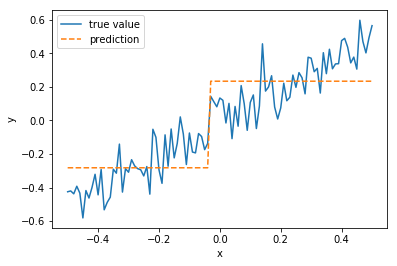

In [12]:
simpletree = DecisionTreeRegressor(max_depth=1)
simpletree.fit(x.reshape((m+1,1)),y)
    
yhat = simpletree.predict(x.reshape((m+1,1)))
plt.figure()
plt.plot(x,y,label=u'true value')
plt.plot(x,yhat,label=u'prediction',linestyle='--')
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

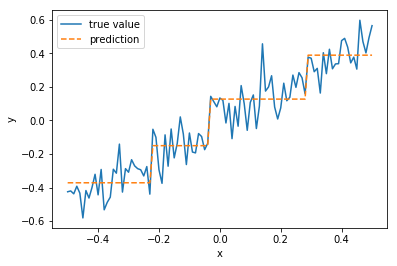

In [13]:
#2层决策树
simpletree2 = DecisionTreeRegressor(max_depth=2)
simpletree2.fit(x.reshape((m+1,1)),y)
    
yhat2 = simpletree2.predict(x.reshape((m+1,1)))
plt.figure()
plt.plot(x,y,label=u'true value')
plt.plot(x,yhat2,label=u'prediction',linestyle='--')
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 决策树的训练等同于分割点的选择。

一个简单决策树需要确定3个变量：分割点的值、分割后生成的两组数据的的预测值。

训练此决策树的目标就是使得预测值的平方误差最小。

下面一一层决策树为例，以手工代码演示（不调用算法包）。

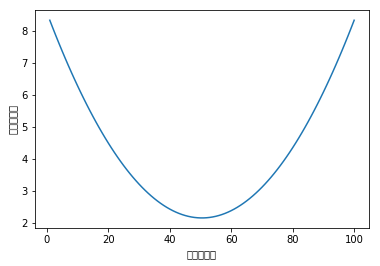

49 -0.010000000000000009


In [15]:
# 分割点计算（穷尽所有可能寻找最好的）

sses = []
xMin = []
for i in range(1, len(x)):
    # 数据分割成左右2组
    lx = x[:i]; rx = x[i:]

    # 以平均值作为各组的预测值
    lxAvg = lx.mean(); rxAvg = rx.mean()

    # 分别计算左右误差平方和，进而求出总的误差平方和
    sse = ((lx-lxAvg)**2).sum() + ((rx-rxAvg)**2).sum()

    # 记录当前分割误差及对应的分割点
    sses.append(sse)
    xMin.append(lx.max())

plt.plot(range(1, m+1), sses)
plt.xlabel(u'分割点索引')
plt.ylabel(u'误差平方和')
plt.show()

minSse = min(sses)
idxMin = sses.index(minSse)
print (idxMin, xMin[idxMin])

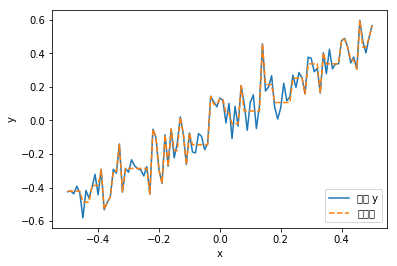

In [16]:
#  6层决策树(层数过高的情况)
simpleTree6 = DecisionTreeRegressor(max_depth=6)
simpleTree6.fit(x.reshape((m+1,1)), y)

# 节点太多，无法生成图像
# with open("simpleTree6.dot", 'w') as f:
#     f = tree.export_graphviz(simpleTree6, out_file=f)

# 根据6层决策树预测并绘图比较
yHat  = simpleTree6.predict(x.reshape((m+1,1)))
plt.figure()
plt.plot(x, y, label=u'真值 y')
plt.plot(x, yHat, label=u'树决策', linestyle='--')
plt.legend(bbox_to_anchor=(1,0.2))
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

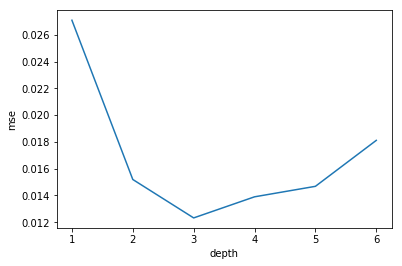

In [28]:
nrow = len(x)

xdata = x.reshape((nrow,1))

depthlist = list(range(1,7))
nxval = 10
xvalmse = []
# 深度循环
for idepth in depthlist:
    
    ooserrors = 0
    # 10折交叉验证循环
    for ixval in range(nxval):
        # 第ixval折验证的训练集和测试集的切分
        idxtest = [i for i in range(nrow) if i%nxval == ixval%nxval]
        idxtrain = [i for i in range(nrow) if i%nxval != ixval%nxval]    
        xtest = xdata[idxtest,:]; ytest = y[idxtest]
        xtrain = xdata[idxtrain,:]; ytrain = y[idxtrain]
        # 指定深度的决策树训练
        treemodel = DecisionTreeRegressor(max_depth=idepth)
        treemodel.fit(xtrain,ytrain)
        # 给予当前训练模型的预测
        treeprediction = treemodel.predict(xtest)
        # 计算误差平方和
        ooserrors += ((treeprediction-ytest)**2).sum()
    # 计算当前深度模型的均方误差
    mse = ooserrors/nrow
    xvalmse.append(mse)
    
plt.plot(depthlist,xvalmse)
plt.axis('tight')
plt.xlabel('depth')
plt.ylabel('mse')
plt.show()

计算结果表明，对这个玩具数据集而言， 3层二元决策树是最佳的。  你可是试着增加这个玩具数据集的样本数，重复上面的计算，将会发现随着数据量的增多，最佳二元决策树的最佳深度会增加，并且均方误差会更低一丢丢。